## Examining the Impact of k in k-fold Cross-Validation on Test Mean Squared Error

#### Dillon Luke
#### Department of Psychology, University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)

### Executive Summary

One method to avoid overfitting models is k-fold cross-validation, which involves splitting the data into k subsets, withholding each subset for testing, training the model using the remaining subsets, and aggregating the relevant metric across all models. The purpose of this project was to examine how the choice of k impacts average test mean squared error (MSE) and variance in test MSE under differing conditions of model complexity and error. Results suggested that average test MSE decreases (non-linearly) as k increases, but variance in test MSE increases (linearly) as k increases, particularly for noiser data. Given that increasing k only marginally decreases average test MSE beyond very low values of k but continues to linearly increase variance in test MSE, I recommend k values in the range of 5-20 to achieve the best balance between average and variance in test MSE.

### Import Packages

Below are the necessary packages for this project.

In [1]:
import os                                                   # for working directory 
import numpy as np                                          # for working with arrays
import scipy.stats as st                                    # statistical methods
import pandas as pd                                         # for working with dataframes
import matplotlib.pyplot as plt                             # for creating plots
from sklearn.model_selection import cross_val_score, KFold  # K-fold cross-validation
from sklearn.metrics import mean_squared_error, r2_score    # for model evaluation
from sklearn import linear_model                            # linear regression model
from sklearn.linear_model import Ridge                      # ridge regression model

from sklearn.neighbors import KNeighborsRegressor           # for nearest k neighbours for interpolation
from sklearn.model_selection import GridSearchCV            # hyperparameter grid search for pipeline
from sklearn.pipeline import Pipeline                       # for use with kNN pipeline
from sklearn.pipeline import make_pipeline                  # for use with kNN pipeline

### Functions

Function created to visualize scatterplots between two variables, with separate lines colored by a third grouping variable.

##### CITATION: "visualize_model" and "kNN_interpolation" were adopted for visualization purposes from the "SubsurfaceDataAnalytics_kNearestNeighbor.ipynb" workflow by Dr. Pyrcz, which can be found at: https://github.com/GeostatsGuy/PythonNumericalDemos

In [2]:
###CV results function adapted from: https://stackoverflow.com/questions/47006268/matplotlib-scatter-plot-with-color-label-and-legend-specified-by-c-option      
def CV_results(x,y,z,title,title_size,x_label,x_size,y_label,y_size,x_min,x_max,y_min,y_max,legend_size):
    for z_val in np.unique(z): ### looping over each z value to group by color
        i = np.where(z == z_val) ### tuple with indices of z value 
        plt.scatter(x[i], y[i], label=z_val) ### for z value, plotting y by x
    plt.title(title, size = title_size); plt.xlabel(x_label, size = x_size); plt.ylabel(y_label, size = y_size) ### titles and labels
    plt.xlim(x_min,x_max); plt.ylim(y_min,y_max); plt.legend(prop={'size': legend_size}) ### setting limits
        
### CITATION: visualize model and content of kNN_interpolation pulled from "SubsurfaceDataAnalytics_kNearestNeighbor.ipynb" workflow by Dr. Pyrcz, which can be found at: https://github.com/GeostatsGuy/PythonNumericalDemos
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):
    n_classes = 10
    cmap = plt.cm.RdYlBu ### color map
    xplot_step = (x_max-x_min)/100; yplot_step = (y_max-y_min)/100 ### creating steps for models
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step),
                     np.arange(y_min, y_max, yplot_step)) ### grid for predictor feature space
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) ### use model to make predictions across predictor feature space
    Z = Z.reshape(xx.shape) ### changing shape of response feature to match predictor feature space
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100)) ### contour plot

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black") ### plotting samples in predictor feature space, colored by response feature
    plt.title(title); plt.xlabel(xfeature.name); plt.ylabel(yfeature.name) ### plot titles and labels
    plt.xlim(x_min,x_max); plt.ylim(y_min,y_max) ### plot limits
    cbar = plt.colorbar(im, orientation = 'vertical') ### colorbar orientation 
    cbar.set_label(response.name, rotation=270, labelpad=20) ### label color bar according to response feature
    
def kNN_interpolation(X,y,scaler,folds,k_min,k_max,k_step,p,weights,title):
    pipe = Pipeline([                                           
        ('scaler', scaler), ### scalar for features
        ('knear', KNeighborsRegressor()) ### kNN regression model
    ])
    parameters = { ### dictionary of parameters                                                 
        'scaler': [scaler], ### scaler which is input by user
        'knear__n_neighbors': np.arange(k_min,k_max,k_step,dtype = int), ### k through k_min to k_max, incrementing by k_step
        'knear__metric': ['minkowski'], ### minkowski distance for flexibility
        'knear__p': [p], ### p = 2 for Euclidean
        'knear__weights': [weights] ### 'uniform' or 'distance'
    }
    grid_cv_tuned = GridSearchCV(pipe, parameters, scoring = 'neg_mean_squared_error', cv=KFold(n_splits=folds,shuffle=False),refit = True) ### k-fold cross-validation for grid search for kNN 
    grid_cv_tuned.fit(X,y) ### fitting model
    
    visualize_model(grid_cv_tuned,X.iloc[:,0],X.iloc[:,0].min(),X.iloc[:,0].max(),X.iloc[:,1],X.iloc[:,1].min(),X.iloc[:,1].max(),y,y.min(),y.max(),title)           

### Load Data

Dataset:
- "unconv_MV_v5.csv", contains synthetic well data with a variety of geological properties

Features:
- For the purposes of examining the choice of k in k-fold Cross Validation (kFCV), I will predict production (production rate in thousands of cubic feet per day, MCFPD) from permeability (ability of fluid to pass through material measured in millidarcies, mD)

In [3]:
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv") ### loading dataset
df.head() ### examining first couple of rows

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


As an initial overview, I will first examine basic information about the dataset including:
- number of samples
- descriptive statistics of the features

In [4]:
df.describe().transpose() ### examining descriptive statistics of dataset

,count,mean,std,min,25%,50%,75%,max
Well,200.0,100.500000,57.879185,1.000000,50.750000,100.500000,150.250000,200.000000
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,4311.219852,992.038414,2107.139414,3618.064513,4284.687348,5086.089761,6662.622385


Based on this information, the dataset includes 200 well samples, each with unique values across a variety of geological features.

Given purpose of analyses is to predict production from permeability, I will:
- remove all features from dataset except for production and permeability
- set min and max values for these features for the purposes of plotting
- plot production from porosity to examine bivariate distribution

Text(0.5, 1.0, 'Production by Permeability')

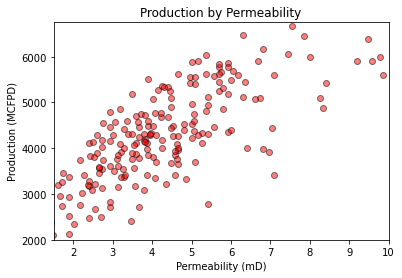

In [5]:
df = df.loc[:,['Perm','Prod']] ### selecting relevant features

perm_min = 1.50; perm_max = 10.00 ### setting min and max parameters for permeability for plotting
prod_min = 2000; prod_max = 6750 ### setting min and max parameters for production for plotting

plt.scatter(df['Perm'],df['Prod'],c='red',alpha=0.5,edgecolor = 'black') ### examining relation between production vs. permeability
plt.xlim(perm_min,perm_max); plt.ylim(prod_min,prod_max) ### setting limits for axes
plt.xlabel("Permeability (mD)") ### x-axis label
plt.ylabel("Production (MCFPD)") ### y-axis label
plt.title("Production by Permeability") ### plot title

As can be seen in the plot of production (MCFPD) vs. permeability (mD), features form a bivaraite Gaussian distribution.

Feature transformation:
- some analyses will add error to the response feature
- features will be standardized to ensure that test MSE is comparable across analyses

In [6]:
#Citation: code adapted from "SubsurfaceDataAnalytics_Feature_Transformations.ipynb", which can be found at Dr. Pyrcz's github: https://github.com/GeostatsGuy/PythonNumericalDemos
from sklearn.preprocessing import StandardScaler ### importing scaler for standardization

scaler = StandardScaler() ### scaler instantiation 
sfeatures = scaler.fit_transform(df.values) ### standardizing all feature values 
df_st = pd.DataFrame(sfeatures, index=df.index, columns=df.columns) ### creating dataframe with standardized features
df_st.describe().transpose() ### confirming feature standardization

perm=df_st['Perm'].values.reshape(200,1) ### creating 200 x 1 numpy array of standardized permeability values
prod=df_st['Prod'].values.reshape(200,1) ### creating 200 x 1 numpy array of standardized production values

### Examining the Impact of k in k-fold Cross-Validation on Test MSE: Overview

To examine how the value of k in k-fold cross-validation impacts average test MSE and variance in test MSE across folds across differing levels of complexity and error, the workflow will include the following steps:

1. Simple Linear Regression Model: k-fold cross-validation for simple linear regression model across all values of k (2 to n) over L realizations
2. Ridge Regression Models: manipulate model complexity by performing k-fold cross-validation for ridge regression models by lambda values and all values of k (2 to n) over L realizations
3. Linear Regression Models with Added Error: manipulate model error by performing k-fold cross-validation for linear regression model by amount of error added and all values of k (2 to n) over L realizations

### Step 1: Simple Linear Regression Model: Cross-validation by k over L realizations

First, I will examine impact of k in k-fold cross-validation for a simple linear regression model across all values of k (2 to n) and L realizations.

For this purpose, I need to: 
- set range of k values (k)
- number of realizations (L)
- instantiate linear model (lm)

In [7]:
### setting range of k values and number of L realizations
k = list(range(2,len(df_st)+1)) ### list of all posible k values ranging from 2 to n
L = 10 ### number of realizations for each value of k in k-fold cross-validation

lm = linear_model.LinearRegression() ### instantiate linear regression model

For each value of k:
- run L realizations
- for each realization, perform k-fold cross-validation, record test MSE across all k folds, and record average and variance in test MSE across the folds (r_mean, r_var)
- after all realizations completed, record k value, average test MSE across realizations, and average variance in test MSE across realizations (lm_results)

##### NOTE: The next block takes an extended time to run.

In [8]:
### creating numpy array called results with a row for each k value and columns reflecting: k-value, average test MSE across realizations, variability in test MSE across realizations
lm_results = np.zeros((len(k),3))  

for count, val in enumerate(k): ### loop over all values of k, keeping count
    
    r_mean = np.zeros(L) ### for given value of k, 1d array to store mean of test MSE across folds for each of L realizations 
    r_var = np.zeros(L) ### for given value of k, 1d array to store variance in test MSE across folds for each of L realizations 
    
    for i in range(L): ### given current k value, loop L times for L realizations
        kfold = KFold(n_splits=val, shuffle=True, random_state=1+i) ### for current realization, set new seed for k folds
        realization = -1*cross_val_score(lm,perm,prod,scoring = "neg_mean_squared_error", cv = kfold, n_jobs = -1) ### for current realization, get test MSE for each of k folds
        r_mean[i] = realization.mean() ### for current realization, record average test MSE across k folds
        r_var[i] = realization.var() ### for current realization, record variance in test MSE across k folds
    
    ### after L realizations for k, record: 
    ### 1. value of k
    ### 2. the average of average test MSE values across realizations
    ### 3. average of variance in test MSE across realizations
    lm_results[count] = [val,r_mean.mean(),r_var.mean()]  

The results of the above analyses are stored in lm_results, a (n-1) x 3 numpy array which stores the k value, average test MSE across realizations, and average variance in test MSE across realizations.

The results of the analyses are converted to a dataframe.

In [9]:
### creating dataframe with k values, average test MSE across k folds averaged over L realizations, and variance in test MSE across k folds averaged over L realizations
lm_data = pd.DataFrame(lm_results, columns = ['k','MSE_mean','MSE_var']) 
lm_data.head()

print("Value of k minimizing average test MSE: " + str(lm_data.loc[np.argmin(lm_data['MSE_mean'].values),'k'])) 
print("Value of k minimizing variance in test MSE: " + str(lm_data.loc[np.argmin(lm_data['MSE_var'].values),'k'])) 

Value of k minimizing average test MSE: 143.0
Value of k minimizing variance in test MSE: 2.0


A k value of 143 minimized average test MSE, and a k value of 2 minimized variance in test MSE. 

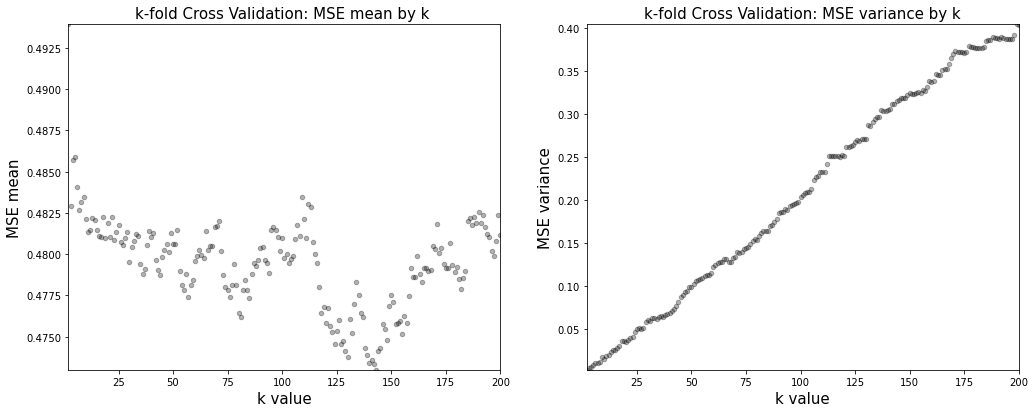

In [10]:
### Plotting average test MSE and variance in test MSE by value of k (each averaged across L realizations) 
plt.subplot(121)
plt.scatter(lm_data['k'].values, lm_data['MSE_mean'].values,  color='black', s = 20, alpha = 0.3) ### plotting average test MSE by k
plt.title('k-fold Cross Validation: MSE mean by k ', size = 15); plt.xlabel('k value', size = 15); plt.ylabel('MSE mean', size = 15) ### titles and labels
plt.xlim(2,len(df_st)); plt.ylim(lm_data['MSE_mean'].min(),lm_data['MSE_mean'].max()) ### setting limits: x between 2 and n, y between min and max average test MSE value

plt.subplot(122)
plt.scatter(lm_data['k'].values, lm_data['MSE_var'].values,  color='black', s = 20, alpha = 0.3) ### plotting variance in test MSE by k
plt.title('k-fold Cross Validation: MSE variance by k', size = 15); plt.xlabel('k value', size = 15); plt.ylabel('MSE variance', size = 15) ### titles and labels
plt.xlim(2,len(df_st)); plt.ylim(lm_data['MSE_var'].min(),lm_data['MSE_var'].max()) ### setting limits: x between 2 and n, y between min and max variance in test MSE value

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2) ### adjusting plots
plt.show() ### showing plots

Based on the above scatterplots:
- increasing k reduced average test MSE, with largest reductions occurring at lower values of k
- increasing k increased variance in test MSE in a linear manner

### Step 2: Ridge Regression Models: Cross-validation by lambda values and k over L realizations

Next, I will examine how manipulating model complexity influences the impact of k in k-fold cross-validation on average test MSE and variance in test MSE. To this end, I will examine impact of k in k-fold cross-validation for ridge regression models by various lambda values and all values of k (2 to n) over L realizations.

For this purpose, I need to: 
- set range of k values (k)
- number of realizations (L)
- set number and range of lambda values (lambda_num, lambdas)

Notes: Only a subset of lambda values over a range were chosen because iterating over all lambda values would be computationally expensive. One value of lambda was intentionally set to zero (equivalent to simple linear regression) for the sake of comparison to the prior analyses.

In [11]:
### setting range of k values and number of L realizations
k = list(range(2,len(df_st)+1)) ### list of all posible k values ranging from 2 to n
L = 10 ### number of realizations for each value of k in the k-fold cross-validation

### setting range of lambda values
lambda_num = 5 ### number of lambda values to examine
lambdas = np.linspace(0.0,100.0,lambda_num) ### range of tested lambda values

For each value of lambda:
- instantiate the ridge regression model
- iterate over all values of k for k-fold cross-validation

For each value of k:
- run L realizations
- for each realization, perform k-fold cross-validation, record test MSE across all k folds, and record average test MSE and variance in test MSE across all k folds (r_mean, r_var)
- after all realizations completed, record lambda value, k value, average test MSE across realizations, and average variance in test MSE across realizations (ridge_results)

##### NOTE: The next block takes an extended time to run.

In [12]:
### creating numpy array called ridge_results with a row for each lambda x k value and columns reflecting: lambda value, k-value, average test MSE across realizations, variability in test MSE across realizations
ridge_results = np.zeros((len(k)*lambda_num,4)) 

for count1, lam in enumerate(lambdas):  ### loop over all values of lambda, keeping count
    
    ridge_reg = Ridge(alpha=lam) ### instantiate ridge regression model with lambda value
    
    for count2, val in enumerate(k): ### given current lambda value, loop over all values of k, keeping count
        
        r_mean = np.zeros(L) ### for given value of lambda and k, 1d array to store mean of test MSE across folds for each of L realizations
        r_var = np.zeros(L) ### for given value of lambda and k, 1d array to store variance in test MSE across folds for each of L realizations 
        
        for i in range (L): ### given current lambda and k value, loop L times for L realizations
            kfold = KFold(n_splits=val, shuffle=True, random_state=1+i) ### for current realization, set new seed for k folds
            realizations = -1*cross_val_score(ridge_reg,perm,prod,scoring = "neg_mean_squared_error", cv = kfold, n_jobs = -1) ### for current realization, get test MSE for each of k folds
            r_mean[i] = realizations.mean() ### for current realization, record average test MSE across k folds
            r_var[i] = realizations.var() ### for current realization, record variance in test MSE across k folds
            
        ### after L realizations for k, record: 
        ### 1. value of lambda
        ### 2. value of k
        ### 3. the average of average test MSE values across realizations
        ### 4. average of variance in test MSE across realziations
        ridge_results[(len(k)*count1)+count2] = [lam,val,r_mean.mean(),r_var.mean()]

The results of the above analyses are stored in ridge_results, a ((n-1)*lambda_num) x 4 numpy array which stores the lambda value, the k value, average test MSE across realizations, and average variance in test MSE across realizations.

The results of the analyses are converted to a dataframe.

In [13]:
### creating dataframe with lambda values, k values, average test MSE across k folds averaged over L realizations, and variance in test MSE across k folds averaged over L realizations
ridge_data = pd.DataFrame(ridge_results, columns = ['Lambda','k','MSE_mean','MSE_var'])
ridge_data.head()

print("Value of lambda and k minimizing average test MSE: ") 
print("Lambda: " + str(ridge_data.loc[np.argmin(ridge_data['MSE_mean'].values),'Lambda']))
print("k: " + str(ridge_data.loc[np.argmin(ridge_data['MSE_mean'].values),'k']))

print("Value of lambda and k minimizing variance in test MSE: ")
print("Lambda: " + str(ridge_data.loc[np.argmin(ridge_data['MSE_var'].values),'Lambda']))
print("k: " + str(ridge_data.loc[np.argmin(ridge_data['MSE_var'].values),'k']))

Value of lambda and k minimizing average test MSE: 
Lambda: 0.0
k: 143.0
Value of lambda and k minimizing variance in test MSE: 
Lambda: 25.0
k: 2.0


A lambda value of 0 and a k value of 143 minimized average test MSE, and a lambda value of 25 and a k value of 2 minimized variance in test MSE. 

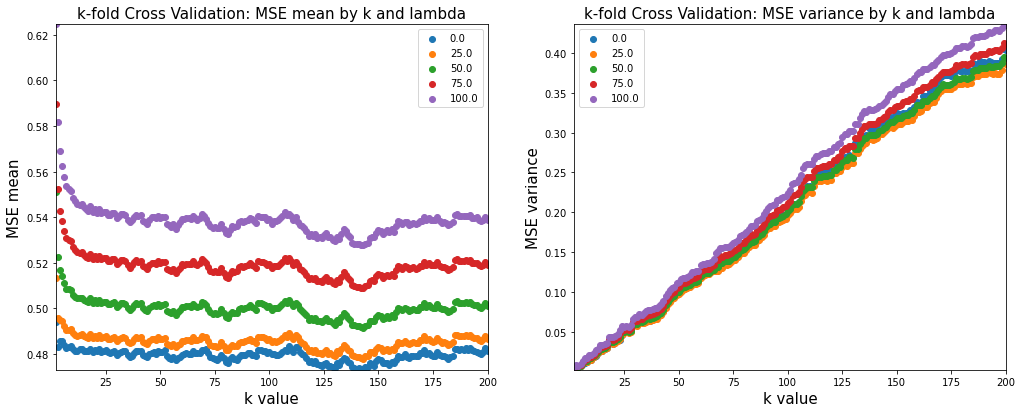

In [14]:
### Plotting average test MSE and variance in test MSE by value of lambda and k (each averaged across L realizations) 
plt.subplot(121)
CV_results(ridge_data['k'].values,ridge_data['MSE_mean'].values,ridge_data['Lambda'].values,
                 'k-fold Cross Validation: MSE mean by k and lambda',15,'k value',15,'MSE mean',15,2,
                  len(df_st),ridge_data['MSE_mean'].min(),ridge_data['MSE_mean'].max(),10)

plt.subplot(122)
CV_results(ridge_data['k'].values,ridge_data['MSE_var'].values,ridge_data['Lambda'].values,
                 'k-fold Cross Validation: MSE variance by k and lambda',15,'k value',15,'MSE variance',15,2,
                  len(df_st),ridge_data['MSE_var'].min(),ridge_data['MSE_var'].max(),10)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2) ### adjusting plots
plt.show() ### showing plots

The scatterplots above show average test MSE (left) and variance in test MSE (right) as a function of k value (x-axis) and lambda value (color).

For added visualization of the relation between average/variance in test MSE and k by lambda values, I will use k-nearest neighbors to interpolate expected average/variance in test MSE across k by lambda value space.

In [15]:
k_subset = np.linspace(2,200,10) ### selecting subset of k values
ridge_data_subset = ridge_data.loc[ridge_data['k'].isin(k_subset),:] ### extracting subset of data with selected k values
X = ridge_data_subset.loc[:,["k","Lambda"]] ### the predictor feature space is comprised of k by lambda values
y_mean = ridge_data_subset.loc[:,"MSE_mean"] ### the response feature is average test MSE
y_var = ridge_data_subset.loc[:,"MSE_var"] ### the response feature is variance in test MSE

Above, I first took a subset of the data to create a grid of datapoints across the k by lambda value feature space. Next, I will use the "kNN_interpolation" function to interpolate average/variance in test MSE values.

##### CITATION: the "kNN_interpolation" function uses the "visualize_model" function and k-nearest neighbors workflow from the "SubsurfaceDataAnalytics_kNearestNeighbor.ipynb" workflow by Dr. Pyrcz, which can be found at: https://github.com/GeostatsGuy/PythonNumericalDemos

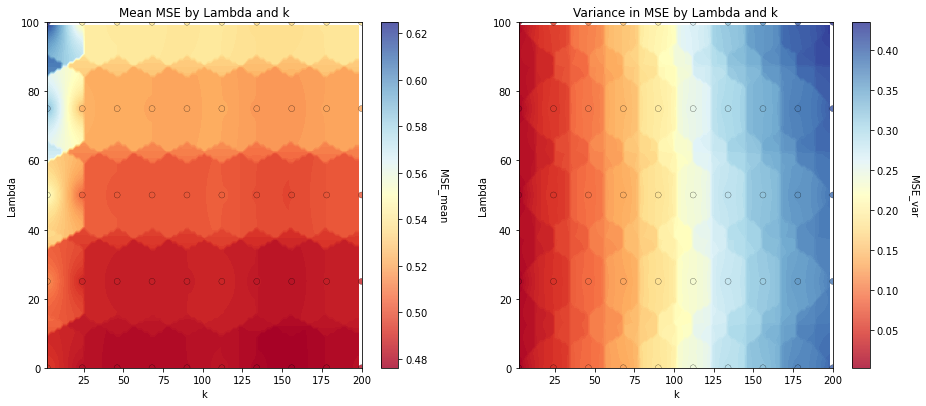

In [16]:
plt.subplot(121)
kNN_interpolation(X=X,y=y_mean,scaler=StandardScaler(),folds=10,k_min=1,k_max=20,k_step=1,p=2,weights='distance',title="Mean MSE by Lambda and k") # standardize features, interpolate average test MSE across feature space by performing kNN regression with 10-fold cross-validation (hypertuning model for k values between 1 and 20), weighting by Euclidean distance

plt.subplot(122)
kNN_interpolation(X=X,y=y_var,scaler=StandardScaler(),folds=10,k_min=1,k_max=20,k_step=1,p=2,weights='distance',title="Variance in MSE by Lambda and k") # standardize features, interpolate variance in test MSE across feature space by performing kNN regression with 10-fold cross-validation (hypertuning model for k values between 1 and 20), weighting by Euclidean distance

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2);
plt.show()

Based on the above visualizations:
- across all lambda values, increasing k reduced average test MSE, with largest reductions occurring at lower values of k in all cases
- as lambda values increased, average test MSE also increased across all k, suggesting that simple linear regression is superior to ridge regression in this case (hyperparameter tuning)
- across all lambda values, increasing k increased variance in test MSE in a linear manner
- the impact of lambda on the strength of the relation between k and variance in test MSE (i.e., slope) is unclear in this data

### Step 3: Linear Regression Model with Added Error: Cross-validation by k and added error over L realizations

Next, I will examine how manipulating model error influences the impact of k in k-fold cross-validation on average test MSE and variance in test MSE. To this end, I will examine impact of k in k-fold cross-validation for linear regression models by various amounts of added error and all values of k (2 to n) over L realizations.

For this purpose, I need to: 
- set range of k values (k)
- number of realizations (L)
- set number and range of amount of error added to response feature (error_num, errors)
- instantiate linear model (lm)
- set random seed for reproducicability of added error

Notes: Error was added to response feature in terms of response feature standard deviations. One value of added error was intentionally set to zero (equivalent to original simple linear regression) for the sake of comparison to the analyses in the first step.

In [17]:
### setting range of k values and number of L realizations
k = list(range(2,len(df_st)+1)) ### list of all posible k values ranging from 2 to n
L = 10 ### number of realizations for each value of k in the k-fold cross-validation

### setting range of amounts of added error
error_num = 5 ### number of added error values to examine
errors = np.linspace(0.0,df['Prod'].std()*4,error_num) ### range of added error values: from 0 to 4 production response feature standard deviation

lm = linear_model.LinearRegression() ### instantiate linear regression model

np.random.seed(1) ### random seed to reproduce random error

For each amount of added error:
- add the error to the response feature (unstandardized)
- standardize response feature for sake of comparison of test MSE
- iterate over all values of k for k-fold cross-validation

For each value of k:
- run L realizations
- for each realization, perform k-fold cross-validation with new random number seed, record test MSE across all k folds, record average test MSE and variance in test MSE across all k folds (r_mean, r_var)
- after realizations, record amount of added error, k value, average test MSE across realizations, and average variance in test MSE across realizations (error_results)

##### NOTE: The next block takes an extended time to run.

In [18]:
### creating numpy array called error_results with a row for each added error x k value and columns reflecting: added error (in response feature standard deviations), k-value, average test MSE across realizations, variability in test MSE across realizations
error_results = np.zeros((len(k)*error_num,4)) 

for count1, err in enumerate(errors): ### loop over all amounts of added error, keeping count
    
    prod = df['Prod'] + np.random.normal(loc=0.0,scale=err,size = len(df['Prod'])) ### adding given amount of error to production response feature, from "SubsurfaceDataAnalytics_kNearestNeighbour.ipynb" workflow at https://github.com/GeostatsGuy/PythonNumericalDemos
    prod = ((prod - prod.mean())/prod.std()).values.reshape(200,1) ### standardizing response feature manually
    
    for count2, val in enumerate(k): ### given current amount of added error, loop over all values of k, keeping count
        
        r_mean = np.zeros(L) ### for given amount of added error and k, 1d array to store mean of test MSE across folds for each of L realizations 
        r_var = np.zeros(L) ### for given amount of added error and k, 1d array to store variance in test MSE across folds for each of L realizations 
        
        for i in range (L): ### given current amount of added error and k value, loop L times for L realizations
            kfold = KFold(n_splits=val, shuffle=True, random_state=1+i) ### for current realization, set new seed for k folds
            realizations = -1*cross_val_score(lm,perm,prod,scoring = "neg_mean_squared_error", cv = kfold, n_jobs = -1) ### for current realization, get test MSE for each of k folds
            r_mean[i] = realizations.mean() ### for current realization, record average test MSE across k folds
            r_var[i] = realizations.var() ### for current realization, record variance in test MSE across k folds
            
        ### after L realizations for k, record: 
        ### 1. amount of added error
        ### 2. value of k
        ### 3. the average of average test MSE values across realizations
        ### 4. average of variance in test MSE across realziations    
        error_results[(len(k)*count1)+count2] = [count1,val,r_mean.mean(),r_var.mean()]

The results of the above analyses are stored in error_results, a ((n-1)*error_num) x 4 numpy array which stores amount of added error, the k value, average test MSE across realizations, and average variance in test MSE across realizations.

The results of these analyses are converted to a dataframe.

In [19]:
### creating dataframe with amount of added error (in terms of repsonse feature standard deviations), k values, average test MSE across k folds averaged over L realizations, and variance in test MSE across k folds averaged over L realizations
error_data = pd.DataFrame(error_results, columns = ['Err_SD','k','MSE_mean','MSE_var'])
error_data.head()

print("Amount of added error and k minimizing average test MSE: ") 
print("Amount of added error: " + str(error_data.loc[np.argmin(error_data['MSE_mean'].values),'Err_SD']))
print("k: " + str(error_data.loc[np.argmin(error_data['MSE_mean'].values),'k']))

print("Amount of added error and k minimizing variance in test MSE: ")
print("Amount of added error: " + str(error_data.loc[np.argmin(error_data['MSE_var'].values),'Err_SD']))
print("k: " + str(error_data.loc[np.argmin(error_data['MSE_var'].values),'k']))

Amount of added error and k minimizing average test MSE: 
Amount of added error: 0.0
k: 143.0
Amount of added error and k minimizing variance in test MSE: 
Amount of added error: 0.0
k: 2.0


Adding no error and a k value of 143 minimized average test MSE, and adding no error and a k value of 2 minimized variance in test MSE. 

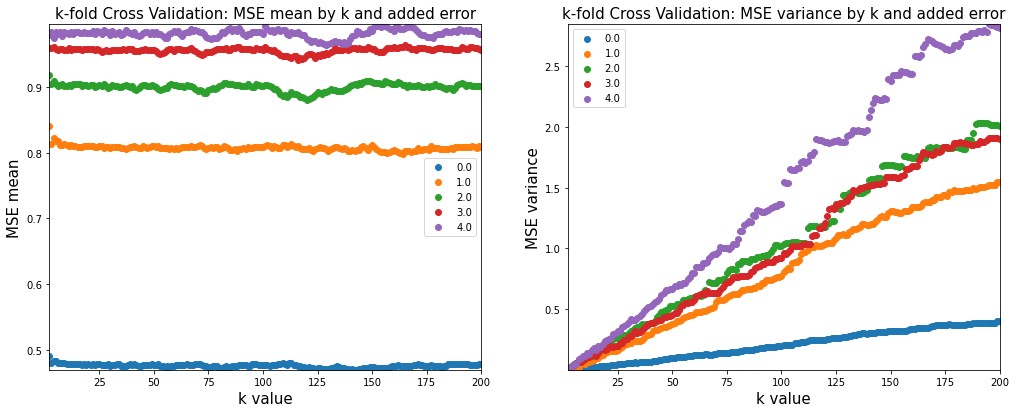

In [20]:
### Plotting average test MSE and variance in test MSE by amount of added error and k (each averaged across L realizations) 
plt.subplot(121)
CV_results(error_data['k'].values,error_data['MSE_mean'].values,error_data['Err_SD'].values,
                 'k-fold Cross Validation: MSE mean by k and added error',15,'k value',15,'MSE mean',15,2,
                  len(df_st),error_data['MSE_mean'].min(),error_data['MSE_mean'].max(),10)

plt.subplot(122)
CV_results(error_data['k'].values,error_data['MSE_var'].values,error_data['Err_SD'].values,
                 'k-fold Cross Validation: MSE variance by k and added error',15,'k value',15,'MSE variance',15,2,
                  len(df_st),error_data['MSE_var'].min(),error_data['MSE_var'].max(),10)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2) ### adjusting plots
plt.show() ### showing plots

The scatterplots above show average test MSE (left) and variance in test MSE (right) as a function of k value (x-axis) and amount of added error (color).

For added visualization of the relation between average/variance in test MSE and k by added error, I will use k-nearest neighbors to interpolate expected average/variance in test MSE across k by added error value space.

In [21]:
k_subset = np.linspace(2,200,10) ### selecting subset of k values
error_data_subset = error_data.loc[error_data['k'].isin(k_subset),:] ### extracting subset of data with selected k values
X = error_data_subset.loc[:,["k","Err_SD"]] ### the predictor feature space is comprised of k by amount of error added 
y_mean = error_data_subset.loc[:,"MSE_mean"] ### the response feature is average test MSE
y_var = error_data_subset.loc[:,"MSE_var"] ### the response feature is variance in test MSE

Above, I first took a subset of the data to create a grid of datapoints across the k by added error value space. Next, I will use the "kNN_interpolation" function to interpolate average/variance in test MSE values.

##### CITATION: the "kNN_interpolation" function uses the "visualize_model" function and k-nearest neighbors workflow from the "SubsurfaceDataAnalytics_kNearestNeighbor.ipynb" workflow by Dr. Pyrcz, which can be found at: https://github.com/GeostatsGuy/PythonNumericalDemos

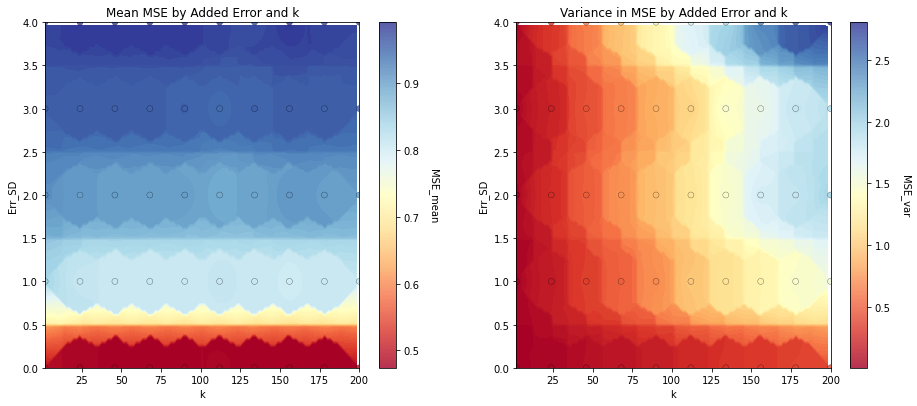

In [22]:
plt.subplot(121)
kNN_interpolation(X=X,y=y_mean,scaler=StandardScaler(),folds=10,k_min=1,k_max=20,k_step=1,p=2,weights='distance',title="Mean MSE by Added Error and k")  # standardize features, interpolate average test MSE across feature space by performing kNN regression with 10-fold cross-validation (hypertuning model for k values between 1 and 20), weighting by Euclidean distance

plt.subplot(122)
kNN_interpolation(X=X,y=y_var,scaler=StandardScaler(),folds=10,k_min=1,k_max=20,k_step=1,p=2,weights='distance',title="Variance in MSE by Added Error and k") # standardize features, interpolate variance in test MSE across feature space by performing kNN regression with 10-fold cross-validation (hypertuning model for k values between 1 and 20), weighting by Euclidean distance

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2);
plt.show()

Based on the above visualizations:
- across amounts of added error, increasing k reduced average test MSE, with largest reductions occurring at lower values of k in all cases
- as amount of error increased, the average test MSE increased overall, which is expected
- across amounts of added error, increasing k increased variance in test MSE in a linear manner
- as amount of error increased, increasing k increased variance in test MSE at a higher rate

### Results

Collectively, these analyses demonstrate:
1. Increasing the value of k in k-fold cross-validation decreases estimated average test MSE under all conditions
2. The largest reductions in estimated average test MSE are at lower values of k
3. Increasing the value of k in k-fold cross-validation linearly increases variance in test MSE under all conditions
4. The largest increases in variance in test MSE are under conditions of added noise

Taken together:
1. A goal in the choice of k should be to reduce average test MSE and variance in test MSE
2. Given that k decreases average test MSE but increases variance in test MSE, there is a trade-off in increasing k
3. Since the largest reductions in average test MSE occur at very low values of k, increasing k beyond 10-20 offers marginal reduction in average test MSE but constant increases in variance in test MSE

Therefore:
1. Values of k in the range of 5-20 seem to achieve the best balance between average test MSE and variance in test MSE

### Dillon Luke, PhD Candidate, University of Texas at Austin

I am a PhD student in the Department of Psychology at the University of Texas at Austin. Please feel free to contact me if you have any questions about this workflow, which I hope was helpful in demonstrating the impact of the choice of k in k-fold cross-validation on the mean and variance in test mean squared error.

All the best,

Dillon Luke

Email: lukedm@utexas.edu
___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin